In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.api import VAR
from datetime import datetime, timedelta
import logging
import pickle
import databento as db

logging.basicConfig(level=logging.INFO)

In [35]:
FIRST_MONTH_PATH = "./data/stock/xnas-itch-20230501-20230531.ohlcv-1m.dbn.zst"

# Read saved .dbn.zst
stored_data = db.DBNStore.from_file(FIRST_MONTH_PATH)

# Convert to dataframe
df = stored_data.to_df()
# df

train_prices = df.pivot_table(index='ts_event', columns='symbol', values='close', aggfunc='first')
train_prices

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
ts_event,,,,,,,,,,,,,,,,,,,,,
2023-05-01 08:00:00+00:00,NaN,NaN,169.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:01:00+00:00,NaN,NaN,169.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:02:00+00:00,NaN,NaN,169.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:03:00+00:00,NaN,NaN,169.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:55:00+00:00,NaN,NaN,NaN,NaN,NaN,102.47,NaN,NaN,413.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-31 23:56:00+00:00,NaN,14.8,177.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-31 23:57:00+00:00,NaN,14.8,177.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
test_path = "data/stock/xnas-itch-20240401-20240430.ohlcv-1m.dbn.zst"
df_test = db.DBNStore.from_file(test_path).to_df()

df_test

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ts_event,,,,,,,,,
2024-04-01 08:00:00+00:00,33,2,7151,152.30,152.51,152.30,152.37,75,GOOG
2024-04-01 08:00:00+00:00,33,2,14261,91.60,91.75,91.55,91.55,21,SBUX
2024-04-01 08:00:00+00:00,33,2,853,187.27,187.27,181.01,181.01,120,AMZN
2024-04-01 08:00:00+00:00,33,2,773,182.32,182.60,182.20,182.20,204,AMD
2024-04-01 08:00:00+00:00,33,2,3695,302.99,302.99,302.99,302.99,30,CRM
...,...,...,...,...,...,...,...,...,...
2024-04-30 23:59:00+00:00,33,2,12273,289.00,289.00,289.00,289.00,11,PANW
2024-04-30 23:59:00+00:00,33,2,2697,334.55,334.55,334.55,334.55,1,CAT
2024-04-30 23:59:00+00:00,33,2,2021,3456.88,3456.88,3456.88,3456.88,10,BKNG


In [37]:
test_prices = df_test.pivot_table(index='ts_event', columns='symbol', values='close', aggfunc='first')
test_prices

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-04-01 08:00:00+00:00,NaN,15.4,171.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:01:00+00:00,NaN,NaN,171.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:02:00+00:00,NaN,NaN,171.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:03:00+00:00,NaN,NaN,171.83,NaN,NaN,NaN,NaN,NaN,507.99,NaN,...,NaN,NaN,NaN,NaN,116.52,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:04:00+00:00,NaN,NaN,171.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 23:55:00+00:00,NaN,NaN,170.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 23:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 23:57:00+00:00,NaN,NaN,170.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


INFO:root:Initial analysis for pair: AAPL, MSFT
/usr/local/Caskroom/miniconda/base/envs/MSE244/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/h6/sy6yc4qn7vg_qrvftw3gqnl00000gn/T/ipykernel_1380/1301122360.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.p_values_df = pd.concat([self.p_values_df, new_row], ignore_index=True)
INFO:root:Running iteration 1/1
INFO:root:Updating decisions for pair: AAPL, MSFT


storing p values and models
Running iterations
update decisions
dict_items([(('AAPL', 'MSFT'), <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper object at 0x1c257d450>)])
Updating decisions for pair: AAPL, MSFT


symbol,AAPL,MSFT
ts_event,,
2024-04-01 08:00:00+00:00,171.52,424.89
2024-04-01 08:01:00+00:00,171.75,424.03
2024-04-01 08:02:00+00:00,171.79,423.32
2024-04-01 08:03:00+00:00,171.83,423.41
2024-04-01 08:05:00+00:00,171.79,423.46
...,...,...
2024-04-30 23:52:00+00:00,170.14,390.43
2024-04-30 23:55:00+00:00,170.10,390.40
2024-04-30 23:57:00+00:00,170.06,390.50


lag order 7


,AAPL_actual,MSFT_actual,AAPL_predicted,MSFT_predicted,vol_AAPL,vol_change_AAPL,vol_std_AAPL,vol_MSFT,vol_change_MSFT,vol_std_MSFT
ts_event,,,,,,,,,,
2024-04-01 08:10:00+00:00,-0.000699,0.000000,-0.000023,0.000041,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:11:00+00:00,0.000000,0.000142,0.000075,0.000057,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:12:00+00:00,-0.000175,0.000047,-0.00003,-0.000056,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:14:00+00:00,0.000350,0.000330,-0.000009,-0.000012,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:16:00+00:00,0.000349,-0.000330,0.000036,-0.000006,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-04-30 23:52:00+00:00,-0.000176,-0.000051,-0.000013,-0.0,0.000034,9.854203e-08,0.000004,0.000020,-1.169809e-06,0.000002
2024-04-30 23:55:00+00:00,-0.000235,-0.000077,0.000025,0.000001,0.000033,-3.821871e-08,0.000004,0.000020,-1.052102e-08,0.000002
2024-04-30 23:57:00+00:00,-0.000235,0.000256,0.000008,-0.000028,0.000033,-3.401704e-07,0.000004,0.000021,6.848965e-07,0.000002


,AAPL_actual,MSFT_actual,AAPL_predicted,MSFT_predicted,vol_AAPL,vol_change_AAPL,vol_std_AAPL,vol_MSFT,vol_change_MSFT,vol_std_MSFT,AAPL_trade,MSFT_trade
ts_event,,,,,,,,,,,,
2024-04-01 08:10:00+00:00,-0.000699,0.000000,-0.000023,0.000041,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
2024-04-01 08:11:00+00:00,0.000000,0.000142,0.000075,0.000057,NaN,NaN,NaN,NaN,NaN,NaN,C,nan
2024-04-01 08:12:00+00:00,-0.000175,0.000047,-0.00003,-0.000056,NaN,NaN,NaN,NaN,NaN,NaN,nan,P
2024-04-01 08:14:00+00:00,0.000350,0.000330,-0.000009,-0.000012,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
2024-04-01 08:16:00+00:00,0.000349,-0.000330,0.000036,-0.000006,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 23:52:00+00:00,-0.000176,-0.000051,-0.000013,-0.0,0.000034,9.854203e-08,0.000004,0.000020,-1.169809e-06,0.000002,nan,nan
2024-04-30 23:55:00+00:00,-0.000235,-0.000077,0.000025,0.000001,0.000033,-3.821871e-08,0.000004,0.000020,-1.052102e-08,0.000002,nan,nan
2024-04-30 23:57:00+00:00,-0.000235,0.000256,0.000008,-0.000028,0.000033,-3.401704e-07,0.000004,0.000021,6.848965e-07,0.000002,nan,nan


INFO:root:Iteration 1 completed


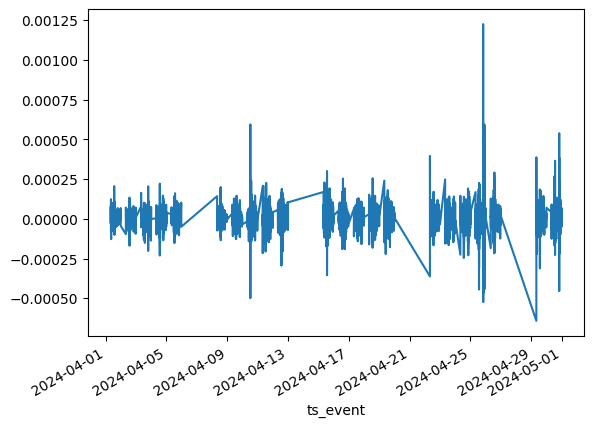

In [72]:
class StraddleSelector:
    def __init__(self, equities, lag_period):
        self.equities = equities
        self.lag_period = lag_period
        self.var_models = {}
        self.results = []
        self.p_values_df = pd.DataFrame(columns=['Ticker1', 'Ticker2', 'P_Value', 'Correlation_Significant', 'Params', "Best_Lag"])
        self.initial_calculation_done = False

    def fetch_historical_data(self, ticker):
        """
        Fetch historical data for a given ticker
        """
        # display(yf.Ticker(ticker).history(period="1y"))
        # return yf.Ticker(ticker).history(period="1y")
        return df[df['symbol'] == ticker]

    def calculate_returns(self, historical_data):
        return np.log(historical_data / historical_data.shift(1)).dropna()

    def check_cointegration(self, merged_hist):
        # display(hist1)
        # display(hist2)
        # Merge the dataframes on their indices using an inner join so only same index values are kept
        # merged_minute_data = hist1.join(hist2, how='inner', lsuffix='_1', rsuffix='_2')

        # _, p_value, _ = coint(merged_minute_data['close_1'], merged_minute_data['close_2'])

        _, p_value, _ = coint(merged_hist['close_1'], merged_hist['close_2'])
        return p_value < 0.05, p_value

    def calculate_rolling_correlation(self, returns1, returns2):
        return rolling_correlation(returns1, returns2, window=self.lag_period)

    def fit_var_model(self, returns1, returns2, ticker1, ticker2):
        model_data = pd.concat([returns1, returns2], axis=1).dropna()
        model_data.columns = [ticker1, ticker2]
        var_model = VAR(model_data)
        return var_model.fit(maxlags=15, ic='aic')

    def store_p_values_and_models(self, ticker1, ticker2, p_value, correlation_significant, var_result):
        best_lag = var_result.k_ar

        coefficients_df = pd.DataFrame(var_result.params)
        # display(coefficients_df)

        params_dict = coefficients_df.to_dict(orient='index')

        new_row = pd.DataFrame({
            'Ticker1': [ticker1],
            'Ticker2': [ticker2],
            'P_Value': [p_value],
            'Correlation_Significant': [correlation_significant],
            # 'Var_Model': [var_result],
            'Best_Lag': [best_lag],
            'Params': [params_dict]
        })
        self.p_values_df = pd.concat([self.p_values_df, new_row], ignore_index=True)
        self.var_models[(ticker1, ticker2)] = var_result

        print("storing p values and models")
        # with open('output/aapl-msft-var.pkl', 'wb') as f:
        #     pickle.dump(var_result, f)

        # save to output/ticker_lags
        self.p_values_df.to_csv(f"output/ticker_lags.csv")

    def initial_calculations(self):
        for i, ticker1 in enumerate(self.equities):
            for ticker2 in self.equities[i+1:]:
                logging.info(f"Initial analysis for pair: {ticker1}, {ticker2}")

                hist1 = self.fetch_historical_data(ticker1)
                hist2 = self.fetch_historical_data(ticker2)

                merged_hist = hist1.join(hist2, how='inner', lsuffix='_1', rsuffix='_2').dropna()

                # _, p_value, _ = coint(merged_minute_data['close_1'], merged_minute_data['close_2'])

                if merged_hist.empty:
                    logging.warning(f"No data for pair: {ticker1}, {ticker2}")
                    continue

                returns1 = self.calculate_returns(merged_hist["close_1"])
                returns2 = self.calculate_returns(merged_hist["close_2"])

                correlation_significant, p_value = self.check_cointegration(merged_hist)
                rolling_corr = self.calculate_rolling_correlation(returns1, returns2)
                significant = test_significance(rolling_corr.dropna())

                if not significant:
                    continue

                var_result = self.fit_var_model(returns1, returns2, ticker1, ticker2)
                # print(var_result.summary())
                self.store_p_values_and_models(ticker1, ticker2, p_value, correlation_significant, var_result)

        self.initial_calculation_done = True

    def fetch_latest_price(self, ticker):
        latest_price = yf.Ticker(ticker).history(period="1d")
        if latest_price.empty:
            logging.warning(f"No latest price data for {ticker}")
            return None
        return latest_price['Close'].iloc[-1]

    # def forecast_volatility_change(self, var_result):
    #     try:
    #         model_data = var_result.endog
    #         lag_order = var_result.k_ar

    #         if len(model_data) >= lag_order:
    #             forecast_input = model_data[-lag_order:]
    #             forecast = var_result.forecast(y=forecast_input, steps=1)
    #             vol_change = (forecast[0, 1] - forecast[0, 0]).item() # Difference in predicted returns
    #             std_change = float(np.std(forecast))
    #             return vol_change, std_change
    #         else:
    #             logging.warning(f"Not enough data points to perform forecasting")
    #             return 0.0, 0.0
    #     except Exception as e:
    #         logging.error(f"Error forecasting volatility change: {e}")
    #         return 0.0, 0.0

    def forecast_volatility_change(self, var_model, test_data, ticker1, ticker2):
        # try:
            # model_data = var_result.endog
        lag_order = var_model.k_ar

        if len(test_data) >= lag_order:
            # Initialize an empty DataFrame to store the predicted values
            predicted_data = pd.DataFrame(columns=[ticker1, ticker2], index = test_data.index[lag_order:])

            print("lag order", lag_order)

            returns1 = self.calculate_returns(test_data[ticker1])
            returns2 = self.calculate_returns(test_data[ticker2])

            returns_concat = pd.concat([returns1, returns2], axis=1).dropna()

            # Loop through each row in test_data
            for i in range(0, len(returns_concat)-lag_order):
                # Extract the current row from test_data
                window = returns_concat.iloc[i:i+lag_order]

                # display(returns_concat)
                
                # Predict the next step ahead using the VAR model
                # print(window[ticker2].shape)
                # print(var_model.summary())
                # display(window[ticker2])
                forecast_results = var_model.forecast(y=window[[ticker1, ticker2]].values, steps=1)
                # forecast_results = var_model.forecast(y=returns_concat.values, steps=1)
                
                # display(forecast_results)
                
                # add to predicted data
                predicted_data.loc[test_data.index[i+lag_order], ticker1] = forecast_results[0][0]
                predicted_data.loc[test_data.index[i+lag_order], ticker2] = forecast_results[0][1]

                # break

            # Concatenate test_data with predicted_data for comparison or further analysis
            # final_predicted_data = pd.concat([test_data, predicted_data], axis=1)
            # merge test_data and predicted_data for comparison
            final_predicted_data = pd.merge(returns_concat, predicted_data, left_index=True, right_index=True, suffixes=('_actual', '_predicted'))

            # Calculate rolling volatility (standard deviation of returns)
            window_size = 20  # You can adjust this window size

            for ticker in [ticker1, ticker2]:
                # Calculate rolling volatility (standard deviation of returns)
                final_predicted_data[f'vol_{ticker}'] = final_predicted_data[f'{ticker}_predicted'].rolling(window=window_size).std()
                
                # Shift the volatility to compute volatility change
                final_predicted_data[f'shifted_vol_{ticker}'] = final_predicted_data[f'vol_{ticker}'].shift(1)
                
                # Calculate volatility change
                final_predicted_data[f'vol_change_{ticker}'] = final_predicted_data[f'vol_{ticker}'] - final_predicted_data[f'shifted_vol_{ticker}']
                
                # Calculate the rolling standard deviation of the volatility (volatility_std)
                final_predicted_data[f'vol_std_{ticker}'] = final_predicted_data[f'vol_{ticker}'].rolling(window=window_size).std()
                
                # Drop the intermediate shifted_volatility column
                final_predicted_data.drop(columns=[f'shifted_vol_{ticker}'], inplace=True)

            display(final_predicted_data)

            # forecast_input = model_data[-lag_order:]
            # forecast = var_result.forecast(y=forecast_input, steps=1)
            # vol_change = (forecast[0, 1] - forecast[0, 0]).item() # Difference in predicted returns
            # std_change = float(np.std(forecast))
            # return vol_change, std_change

            # vol_change = (final_predicted_data[ticker2 + '_predicted'] - final_predicted_data[ticker2 + '_actual']).mean()
            # std_change = (final_predicted_data[ticker2 + '_predicted'] - final_predicted_data[ticker2 + '_actual']).std()

            return final_predicted_data
        else:
            logging.warning(f"Not enough data points to perform forecasting")
            return 0.0, 0.0
        # except Exception as e:
        #     logging.error(f"Error forecasting volatility change: {e}")
        #     return 0.0, 0.0

    def output_trades(self, final_predicted_data, ticker1, ticker2):
        for ticker in (ticker1, ticker2):
            percentile_5  = final_predicted_data[f'{ticker}_predicted'].quantile(0.05)
            percentile_95 = final_predicted_data[f'{ticker}_predicted'].quantile(0.95)

            # Create the AAPL_trade column based on the conditions
            final_predicted_data[f'{ticker}_trade'] = np.where(final_predicted_data[f'{ticker}_predicted'] > percentile_95, 'C', 
                                        np.where(final_predicted_data[f'{ticker}_predicted'] < percentile_5, 'P', np.nan))

        return final_predicted_data

    def update_decisions(self):
        print("update decisions")
        print(self.var_models.items())
        if not self.initial_calculation_done:
            logging.info("Initial calculations not done yet.")
            return

        for (ticker1, ticker2), var_result in self.var_models.items():
            logging.info(f"Updating decisions for pair: {ticker1}, {ticker2}")
            print(f"Updating decisions for pair: {ticker1}, {ticker2}")

            test_data = test_prices[[ticker1, ticker2]].dropna()
            display(test_data)

            # S = self.fetch_latest_price(ticker1)
            # if S is None:
            #     continue

            # vol_change, std_change = self.forecast_volatility_change(var_result, test_data, ticker1, ticker2)
            final_predicted_data = self.forecast_volatility_change(var_result, test_data, ticker1, ticker2)

            final_predicted_data["AAPL_predicted"].plot()

            trades_df = self.output_trades(final_predicted_data, ticker1, ticker2)

            # save to csv 
            trades_df.to_csv(f"output/{ticker1}_{ticker2}_trades.csv")

            display(trades_df)
            
            # predicted_mean_change, predicted_std_change = bayesian_inference(S, vol_change, std_change)

            # expirations = yf.Ticker(ticker1).options
            # # print("expirations")
            # # print(expirations)
            # self.evaluate_straddle_options(ticker1, ticker2, S, expirations, predicted_mean_change)

    def evaluate_straddle_options(self, ticker1, ticker2, S, expirations, predicted_mean_change):
        pair_results = []

        for expiration in expirations:
            T = (pd.to_datetime(expiration) - pd.Timestamp.today()).days / 365.0

            hist1 = self.fetch_historical_data(ticker1)
            returns1 = self.calculate_returns(hist1)
            sigma = returns1.std() * np.sqrt(252)

            strike_min = S * 0.8
            strike_max = S * 1.2
            initial_guess = S

            result = minimize(objective, initial_guess, args=(S, T, 0.05, sigma), bounds=[(strike_min, strike_max)], method='L-BFGS-B')
            K_opt = result.x[0]

            profit_up, profit_down, profit_no_move, total_cost = straddle_profit(S, K_opt, T, 0.05, sigma)
            profits = [profit_up, profit_down, profit_no_move]

            pair_results.append({
                'Expiration': expiration,
                'Strike': K_opt,
                'Total_Cost': total_cost,
                'Profit_Up': profit_up,
                'Profit_Down': profit_down,
                'Profit_No_Move': profit_no_move,
                # 'Profits': profits,
                'Sharpe_Ratio': sharpe_ratio(profits, 0.05),
                'Ticker1': ticker1,
                'Ticker2': ticker2
            })

        self.results.extend(pair_results)
        self.select_best_straddle(pair_results, predicted_mean_change)

    def select_best_straddle(self, pair_results, predicted_mean_change):
        best_result = max(pair_results, key=lambda x: x['Sharpe_Ratio'])

        threshold = 0.05
        if predicted_mean_change > threshold:
            logging.info(f"Best Straddle - Expiration: {best_result['Expiration']}, Strike: {best_result['Strike']}, Total Cost: {best_result['Total_Cost']}")
            logging.info(f"Profit if price moves up: {best_result['Profit_Up']}, Profit if price moves down: {best_result['Profit_Down']}, Profit if no movement: {best_result['Profit_No_Move']}")
            logging.info(f"Sharpe Ratio: {best_result['Sharpe_Ratio']}")
        else:
            logging.info("Predicted price change does not meet the threshold for making a purchase.")

    def run_iterations(self, num_iterations):
        print("Running iterations")
        for i in range(num_iterations):
            logging.info(f"Running iteration {i + 1}/{num_iterations}")
            self.update_decisions()
            logging.info(f"Iteration {i + 1} completed")
            # Print the results for the current iteration
            for result in self.results:
                logging.info(result)

def rolling_correlation(data1, data2, window=30):
    return data1.rolling(window).corr(data2)

def test_significance(correlation_series, alpha=0.05):
    mean_corr = correlation_series.mean()
    std_corr = correlation_series.std()
    t_stat = mean_corr / (std_corr / np.sqrt(len(correlation_series)))
    p_value = 2 * (1 - norm.cdf(np.abs(t_stat)))  # two-tailed test
    return p_value < alpha

def bayesian_inference(S, vol_change, std_change, n=10000):
    predicted_changes = np.random.normal(loc=vol_change, scale=std_change, size=n)
    future_prices = S * (1 + predicted_changes)
    return future_prices.mean(), future_prices.std()

def binomial_tree_american(S, K, T, r, sigma, option_type='call', steps=100):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    option_values = np.zeros((steps + 1, steps + 1))
    
    # Initialize the option values at maturity
    for i in range(steps + 1):
        if option_type == 'call':
            option_values[i, steps] = max(0, S * (u ** (steps - i)) * (d ** i) - K)
        elif option_type == 'put':
            option_values[i, steps] = max(0, K - S * (u ** (steps - i)) * (d ** i))
    
    # Step back through the tree
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            option_value_if_held = np.exp(-r * dt) * (p * option_values[i, j + 1] + (1 - p) * option_values[i + 1, j + 1])
            if option_type == 'call':
                option_value_if_exercised = S * (u ** i) * (d ** (j - i)) - K
            elif option_type == 'put':
                option_value_if_exercised = K - S * (u ** i) * (d ** (j - i))
            
            # Ensure we use scalar values in maximum comparison
            # option_values[i, j] = max(option_value_if_held.item(), option_value_if_exercised)
            option_values[i, j] = max(option_value_if_held.item(), option_value_if_exercised.item())

    
    return option_values[0, 0]

def straddle_profit(S, K, T, r, sigma, steps=100):
    call_price = binomial_tree_american(S, K, T, r, sigma, 'call', steps)
    put_price = binomial_tree_american(S, K, T, r, sigma, 'put', steps)
    total_cost = call_price + put_price
    
    profit_up = max(S + (S * 0.2) - K, 0) + max(K - (S + (S * 0.2)), 0) - total_cost
    profit_down = max(K - (S - (S * 0.2)), 0) + max((S - (S * 0.2)) - K, 0) - total_cost
    profit_no_move = -total_cost
    
    return profit_up, profit_down, profit_no_move, total_cost

def objective(K, S, T, r, sigma, steps=100):
    profit_up, profit_down, profit_no_move, _ = straddle_profit(S, K, T, r, sigma, steps)
    return - (profit_up + profit_down + profit_no_move)  # Minimize negative profit (maximize profit)

def sharpe_ratio(profits, risk_free_rate):
    expected_return = np.mean(profits)
    std_dev = np.std(profits)
    return (expected_return - risk_free_rate) / std_dev

# Define list of 50 equities
equities = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 'V', 'JNJ', 'WMT', 
    'JPM', 'PG', 'UNH', 'DIS', 'NVDA', 'HD', 'MA', 'VZ', 'PYPL', 'ADBE', 
    'NFLX', 'INTC', 'KO', 'PFE', 'CSCO', 'PEP', 'T', 'MRK', 'ABT', 'XOM', 
    'NKE', 'MCD', 'CRM', 'LLY', 'MDT', 'AMGN', 'NEE', 'BA', 'COST', 'AVGO', 
    'IBM', 'HON', 'ACN', 'TMO', 'MMM', 'TXN', 'UNP', 'QCOM', 'LOW'
]
# equities = ['AAPL', 'MSFT', 'GOOGL']
equities = ['AAPL', 'MSFT']

lag_period = 5

# Initialize StraddleSelector and perform initial calculations
straddle_selector = StraddleSelector(equities, lag_period)
straddle_selector.initial_calculations()

# Run for a fixed number of iterations
straddle_selector.run_iterations(num_iterations=1)




In [ ]:
#!pip install scipy numpy pandas yfinance statsmodels scikit-learn websocket-client
